# Analyse long timeseries of CTD data

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import cmocean.cm as cmo
from datetime import datetime
from datetime import timedelta
import gsw

In [2]:
df = pd.read_csv('../../data/ISA_CTD/ctd_isa_all_processed.csv',index_col=0)
df

,Latitude,Longitude,Pressure,Date,Time,Dayofyear,SA,CT
0,78.257,15.5266,1,2011-12-14 12:05:34,0.0,348,34.478605,0.846132
1,78.257,15.5266,2,2011-12-14 12:05:34,0.0,348,34.453490,0.846728
2,78.257,15.5266,3,2011-12-14 12:05:34,0.0,348,34.463543,0.844132
3,78.257,15.5266,4,2011-12-14 12:05:34,0.0,348,34.473596,0.843536
4,78.257,15.5266,5,2011-12-14 12:05:34,0.0,348,34.458529,0.846576
...,...,...,...,...,...,...,...,...
18316,78.257,15.5267,61,2018-09-12 19:15:48,212915414.0,255,34.696629,3.467051
18317,78.257,15.5267,62,2018-09-12 19:15:48,212915414.0,255,34.696934,3.464486
18318,78.257,15.5267,63,2018-09-12 19:15:48,212915414.0,255,34.697539,3.463017
18319,78.257,15.5267,64,2018-09-12 19:15:48,212915414.0,255,34.700356,3.459529


## Plot time series

In [3]:
# interpolate SA and CT to (time,pressure) grid
pressure_array = np.arange(np.min(df['Pressure']),np.max(df['Pressure'])+1,1)
time_array = np.arange(np.min(df['Time']),np.max(df['Time'])+1,60*60*24*7) # 1 week spacing

Time, Pressure = np.meshgrid(time_array,pressure_array)

SA_interp = scipy.interpolate.griddata(points=(df['Time'],df['Pressure']),values=df['SA'],xi=(Time,Pressure),method='nearest')
CT_interp = scipy.interpolate.griddata(points=(df['Time'],df['Pressure']),values=df['CT'],xi=(Time,Pressure),method='nearest')

In [4]:
# get times corresponding with each Nov
start = datetime.strptime(df['Date'][0], '%Y-%m-%d %H:%M:%S')
years_with_nov = np.arange(2012,2018,1)
nov_ticks = np.zeros(len(years_with_nov))
for i in range(len(years_with_nov)):
    nov_ticks[i] = timedelta.total_seconds(datetime(years_with_nov[i],11,1,0,0,0)-start)

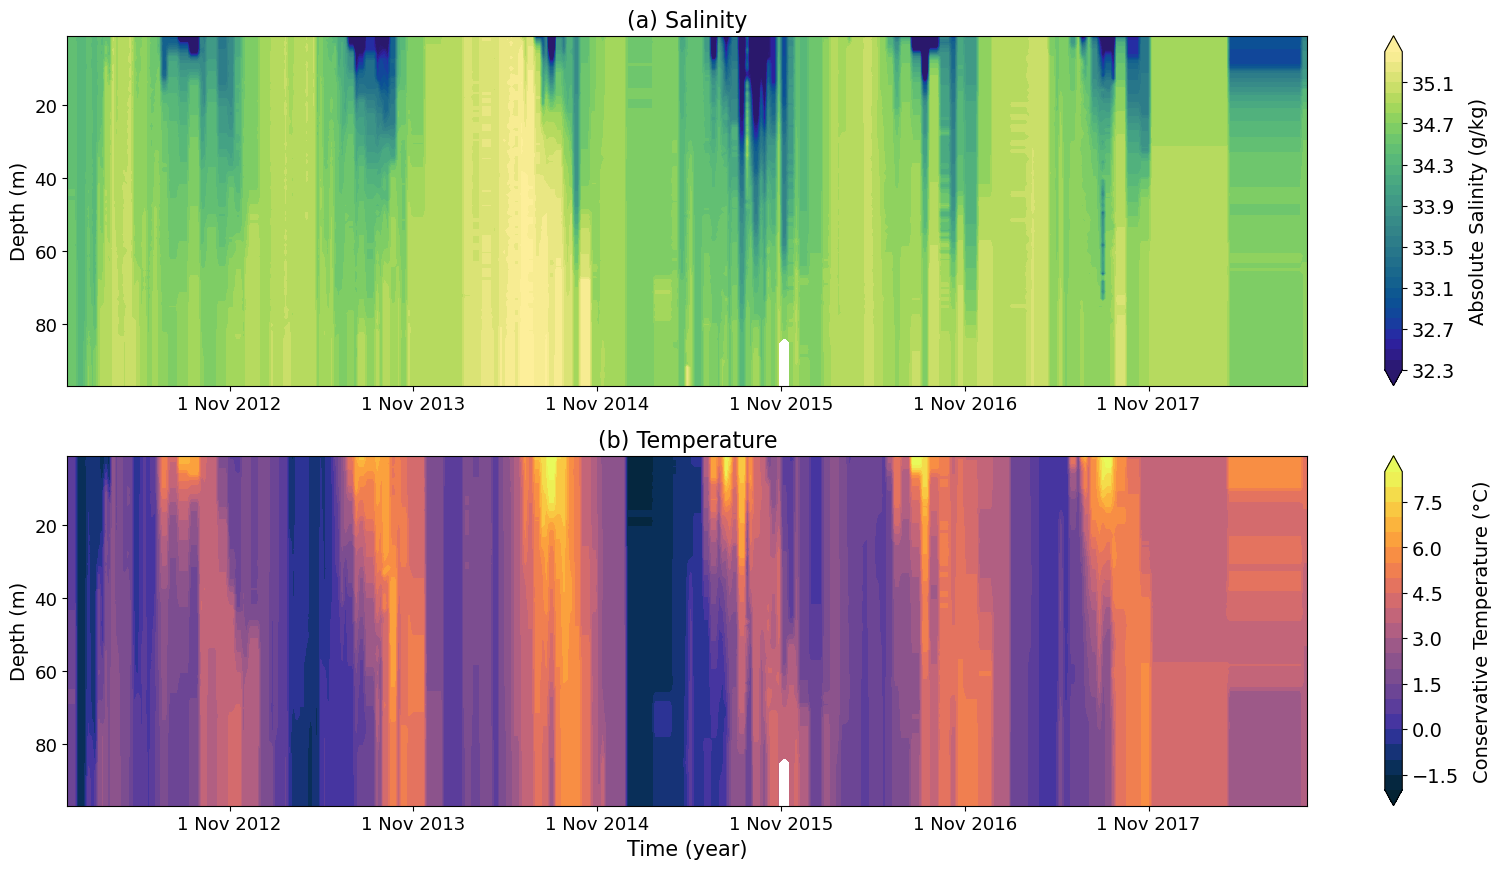

In [7]:
def plotTimeDepth(ax,Time,Vert,data,levels,cmap,label):
    plot = ax.contourf(Time,Vert,data,levels=levels,extend='both',cmap=cmap)
    cbar = plt.colorbar(plot,ax=ax)
    cbar.ax.set_ylabel(label,fontsize=14)
    cbar.ax.tick_params(axis='y', which='both', labelsize=14)
    cbar.ax.get_yaxis().labelpad = 10
    ax.tick_params(axis='both', labelsize=13)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xticks(nov_ticks)
    ax.set_xticklabels(['1 Nov '+str(i) for i in years_with_nov])
    #ax.set_xticks(time_array[years_array])
    #ax.set_xticklabels([dates_array[i].year for i in years_array])
    ax.set_ylabel('Depth (m)',fontsize=14)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,10))
plotTimeDepth(ax1,TimeZ,Depth,SA_interp,levels=np.arange(32.3,35.4,0.1),cmap='cmo.haline',
              label='Absolute Salinity (g/kg)')
plotTimeDepth(ax2,TimeZ,Depth,CT_interp,levels=np.arange(-2,8.51,0.5),cmap='cmo.thermal',
              label='Conservative Temperature ('+'\u00B0'+'C)')
ax2.set_xlabel('Time (year)',fontsize=15)
ax1.set_title('(a) Salinity',fontsize=16)
ax2.set_title('(b) Temperature',fontsize=16)

plt.savefig('../../ocean_plots/timeseries_2012_2018.png',dpi=300,bbox_inches='tight')
plt.show()

In [8]:
print('Mean latitude: %.2f N'%(np.mean(df['Latitude'])))
print('Mean longitude: %.2f E'%(np.mean(df['Longitude'])))

Mean latitude: 78.26 N
Mean longitude: 15.53 E


## Plot TS diagrams

In [9]:
import seaborn as sns
sns.set_style('white')

In [10]:
def TSdiagram(ax,Svals,Tvals,levels):
    """
    Make a TS diagram background: sigma0 contours as function of SA and CT
    """
    Tg,Sg = np.meshgrid(Tvals,Svals)
    sigma = gsw.sigma0(Sg,Tg)
    
    CS = ax.contour(Sg, Tg, sigma, linestyles='dashed', colors='grey', zorder=1, levels=levels)
    plt.clabel(CS, fontsize=12, inline=1, fmt='%0.2f')

In [11]:
def get_SA_CT(pval):
    """
    Select salinity and temperature at certain pressure level
    """
    SA_pval = df.loc[df['Pressure']==pval]['SA']
    CT_pval = df.loc[df['Pressure']==pval]['CT']
    day_pval = df.loc[df['Pressure']==pval]['Dayofyear']
    return SA_pval, CT_pval, day_pval

In [12]:
months_dayofyear = np.zeros(12)
for i in range(12):
    months_dayofyear[i] = datetime(2020,i+1,1).timetuple().tm_yday
    
months_names = ['1 Jan','1 Feb','1 Mar','1 Apr','1 May','1 Jun','1 Jul','1 Aug','1 Sep','1 Oct','1 Nov','1 Dec']

Svals = np.arange(30.5,36,0.1)
Tvals = np.arange(-2,9,0.25)
levels = np.arange(24,36,1)

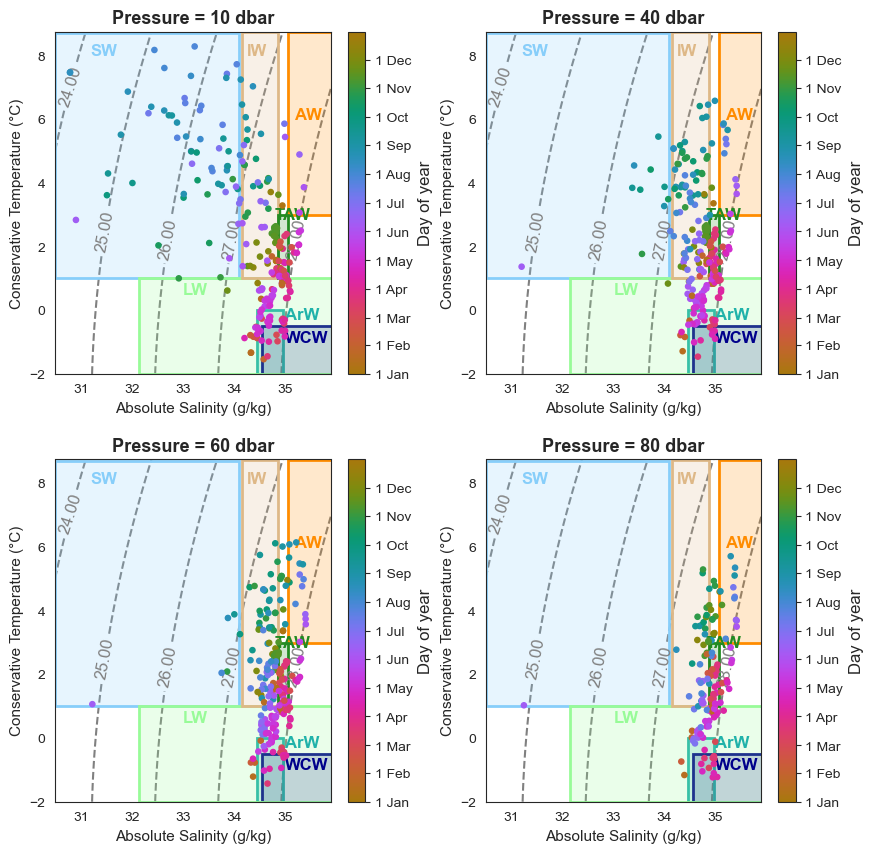

In [13]:
def plot_TS(ax,pval):
    TSdiagram(ax,Svals,Tvals,levels)
    S = ax.scatter(get_SA_CT(pval)[0],get_SA_CT(pval)[1],
                   s=14,cmap='cmo.phase',c=get_SA_CT(pval)[2],zorder=10,vmin=1,vmax=366)
    cbar = plt.colorbar(S,ax=ax,ticks=months_dayofyear)
    cbar.ax.set_yticklabels(months_names)
    cbar.ax.set_ylabel('Day of year',fontsize=12)
    ax.set_title('Pressure = %.f dbar'%pval,fontsize=13,fontweight='bold')
    ax.set_xlabel('Absolute Salinity (g/kg)',fontsize=11)
    ax.set_ylabel('Conservative Temperature ('+'\u00B0'+'C)',fontsize=11)
    ax.set_xlim(Svals[0],Svals[-1])
    ax.set_ylim(Tvals[0],Tvals[-1])
    lw=2
    alpha=0.2
    ax.add_patch(Rectangle((35.07, 3),36-35.07,5.75,
                           fc=colors.to_rgba('darkorange',alpha),edgecolor ='darkorange',linewidth = lw )) # AW
    ax.add_patch(Rectangle((34.46, -2),34.97-34.46, 2,
                           fc=colors.to_rgba('lightseagreen',alpha),edgecolor ='lightseagreen',linewidth=lw)) # ArW
    ax.add_patch(Rectangle((34.56, -2),36-34.56, 1.5,
                           fc=colors.to_rgba('darkblue',alpha),edgecolor ='darkblue',linewidth = lw )) #WCW
    ax.add_patch(Rectangle((30.5, 1),34.1-30.5, 7.7,
                           fc=colors.to_rgba('lightskyblue',alpha),edgecolor ='lightskyblue',linewidth = lw )) #SW
    ax.add_patch(Rectangle((32.15, -2),36-32.15, 3,
                           fc=colors.to_rgba('palegreen',alpha),edgecolor ='palegreen',linewidth = lw )) #LW
    ax.add_patch(Rectangle((34.16, 1),34.87-34.16, 7.75,
                           fc=colors.to_rgba('burlywood',alpha),edgecolor ='burlywood',linewidth = lw )) #IW
    ax.add_patch(Rectangle((34.87, 1),35.07-34.87, 3-1,
                           fc=colors.to_rgba('forestgreen',alpha),edgecolor ='forestgreen',linewidth = lw )) # TAW
    fs=12
    ax.text(35.2,6,'AW',color='darkorange',fontsize=fs,fontweight='bold')
    ax.text(35,-0.3,'ArW',color='lightseagreen',fontsize=fs,fontweight='bold')
    ax.text(34.8,2.85,'TAW',color='forestgreen',fontsize=fs,fontweight='bold')
    ax.text(35,-1,'WCW',color='darkblue',fontsize=fs,fontweight='bold')
    ax.text(31.2,8,'SW',color='lightskyblue',fontsize=fs,fontweight='bold')
    ax.text(33,0.5,'LW',color='palegreen',fontsize=fs,fontweight='bold')
    ax.text(34.25,8,'IW',color='burlywood',fontsize=fs,fontweight='bold')


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))

plot_TS(ax1,10)
plot_TS(ax2,40)
plot_TS(ax3,60)
plot_TS(ax4,80)


plt.subplots_adjust(hspace=0.25,wspace=0.25)
#plt.savefig('../../ocean_plots/timeseries_TSplots_depth.png',dpi=300,bbox_inches='tight')
plt.show()

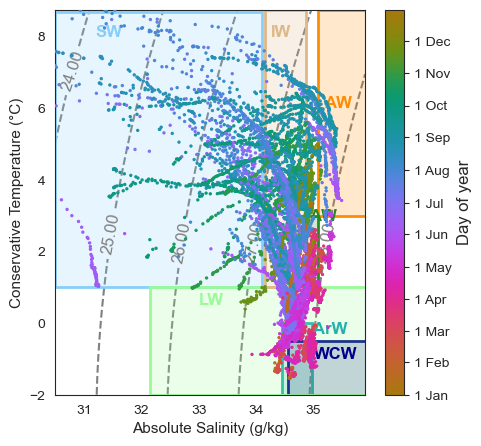

In [14]:
Svals = np.arange(30.5,36,0.1)
Tvals = np.arange(-2,9,0.25)
levels = np.arange(24,36,1)


def plot_TS(ax):
    TSdiagram(ax,Svals,Tvals,levels)
    S = ax.scatter(df['SA'],df['CT'],
                   s=2,cmap='cmo.phase',c=df['Dayofyear'],zorder=10,vmin=1,vmax=366)
    cbar = plt.colorbar(S,ax=ax,ticks=months_dayofyear)
    cbar.ax.set_yticklabels(months_names)
    cbar.ax.set_ylabel('Day of year',fontsize=12)
    ax.set_xlabel('Absolute Salinity (g/kg)',fontsize=11)
    ax.set_ylabel('Conservative Temperature ('+'\u00B0'+'C)',fontsize=11)
    ax.set_xlim(Svals[0],Svals[-1])
    ax.set_ylim(Tvals[0],Tvals[-1])
    lw=2
    alpha=0.2
    ax.add_patch(Rectangle((35.07, 3),36-35.07,5.75,
                           fc=colors.to_rgba('darkorange',alpha),edgecolor ='darkorange',linewidth = lw )) # AW
    ax.add_patch(Rectangle((34.46, -2),34.97-34.46, 2,
                           fc=colors.to_rgba('lightseagreen',alpha),edgecolor ='lightseagreen',linewidth=lw)) # ArW
    ax.add_patch(Rectangle((34.56, -2),36-34.56, 1.5,
                           fc=colors.to_rgba('darkblue',alpha),edgecolor ='darkblue',linewidth = lw )) #WCW
    ax.add_patch(Rectangle((30.5, 1),34.1-30.5, 7.7,
                           fc=colors.to_rgba('lightskyblue',alpha),edgecolor ='lightskyblue',linewidth = lw )) #SW
    ax.add_patch(Rectangle((32.15, -2),36-32.15, 3,
                           fc=colors.to_rgba('palegreen',alpha),edgecolor ='palegreen',linewidth = lw )) #LW
    ax.add_patch(Rectangle((34.16, 1),34.87-34.16, 7.75,
                           fc=colors.to_rgba('burlywood',alpha),edgecolor ='burlywood',linewidth = lw )) #IW
    ax.add_patch(Rectangle((34.87, 1),35.07-34.87, 3-1,
                           fc=colors.to_rgba('forestgreen',alpha),edgecolor ='forestgreen',linewidth = lw )) # TAW
    fs=12
    ax.text(35.2,6,'AW',color='darkorange',fontsize=fs,fontweight='bold')
    ax.text(35,-0.3,'ArW',color='lightseagreen',fontsize=fs,fontweight='bold')
    ax.text(34.8,2.85,'TAW',color='forestgreen',fontsize=fs,fontweight='bold')
    ax.text(35,-1,'WCW',color='darkblue',fontsize=fs,fontweight='bold')
    ax.text(31.2,8,'SW',color='lightskyblue',fontsize=fs,fontweight='bold')
    ax.text(33,0.5,'LW',color='palegreen',fontsize=fs,fontweight='bold')
    ax.text(34.25,8,'IW',color='burlywood',fontsize=fs,fontweight='bold')

fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_TS(ax)

#plt.savefig('../../ocean_plots/timeseries_TSplots_all.png',dpi=300,bbox_inches='tight')